# Calculate heat index and select heatwave days

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image

In [2]:
workspace = 'D:/heat/data/'

## Import temperature and dew point data

In [3]:
# Import climatological Data
weather = pd.read_csv(workspace + 'NOAA/2024_72505394728.csv', low_memory=False)
weather = weather[(weather['TMP'] != '+9999,9') & (weather['DEW'] != '+9999,9')] # Extract outliers
weather = weather[['DATE', 'TMP', 'DEW']] # Select only date, temperature, and dew point columns

# Convert the 'DATE' column to a datetime format
weather['DATE'] = pd.to_datetime(weather['DATE'])

# Extract temperature and dew point in Celsius
def parse_temp(value):
    """Extract °C from NOAA ISD format"""
    raw = value.split(',')[0]
    return float(raw) / 10

weather['temp_c'] = weather['TMP'].apply(parse_temp)
weather['dew_c'] = weather['DEW'].apply(parse_temp)

# Convert Celsius to Fahrenheit
weather['temp_f'] = weather['temp_c'] * 9/5 + 32
weather['dew_f'] = weather['dew_c'] * 9/5 + 32

weather

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f
0,2024-01-01 00:51:00,"+0061,5","-0044,5",6.1,-4.4,42.98,24.08
1,2024-01-01 01:51:00,"+0056,5","-0033,5",5.6,-3.3,42.08,26.06
2,2024-01-01 02:51:00,"+0061,5","-0028,5",6.1,-2.8,42.98,26.96
3,2024-01-01 03:51:00,"+0061,5","-0028,5",6.1,-2.8,42.98,26.96
4,2024-01-01 04:51:00,"+0061,5","-0028,5",6.1,-2.8,42.98,26.96
...,...,...,...,...,...,...,...
11585,2024-12-31 19:51:00,"+0106,1","+0017,1",10.6,1.7,51.08,35.06
11586,2024-12-31 20:51:00,"+0106,1","+0033,1",10.6,3.3,51.08,37.94
11587,2024-12-31 21:51:00,"+0100,1","+0033,1",10.0,3.3,50.00,37.94
11588,2024-12-31 22:51:00,"+0094,1","+0039,1",9.4,3.9,48.92,39.02


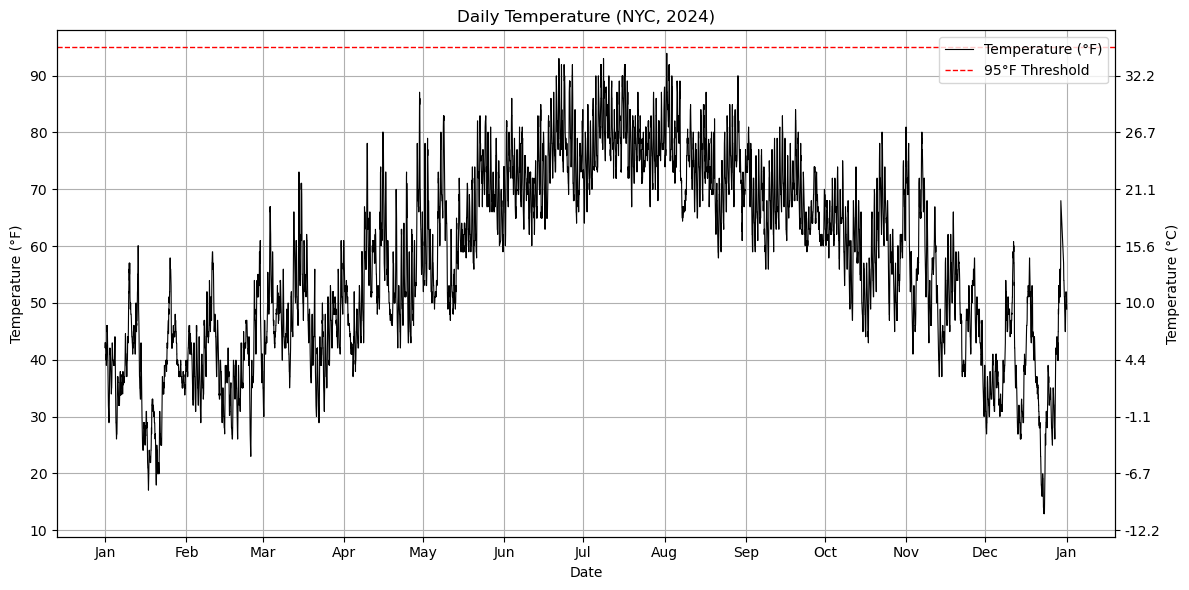

In [4]:
# Function definitions
def fahrenheit_to_celsius(f):
    return (f - 32) * 5.0 / 9.0

def celsius_to_fahrenheit(c):
    return c * 9.0 / 5.0 + 32

# Create main axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature in Fahrenheit
ax1.plot(weather["DATE"], weather["temp_f"], linewidth=0.8, label="Temperature (°F)", color="black")
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°F)")
ax1.set_title("Daily Temperature (NYC, 2024)")
ax1.grid(True)

# Set x-axis to show months
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=0)

# Add reference line at 95°F
ax1.axhline(95, color='red', linestyle='--', linewidth=1, label='95°F Threshold')
ax1.legend(loc='upper right')

# Create secondary y-axis for Celsius
ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (°C)")

# Align Celsius ticks to match 10°F intervals
f_min, f_max = ax1.get_ylim()
f_ticks = np.arange(round(f_min, -1), round(f_max + 1, -1), 10)  # Fahrenheit ticks at 10°F intervals
c_ticks = [fahrenheit_to_celsius(t) for t in f_ticks]           # Convert to Celsius

ax2.set_ylim(fahrenheit_to_celsius(f_min), fahrenheit_to_celsius(f_max))
ax2.set_yticks(c_ticks)
ax2.set_yticklabels([f"{ct:.1f}" for ct in c_ticks])

# Final layout and display
plt.tight_layout()
plt.show()

## Select summer period (June 1 – Aug 31, 2024)

In [5]:
# Set start and end dates as a summer season
start_date = '2024-06-01'
end_date = '2024-09-01'
weather = weather[(weather['DATE'] >= start_date) & (weather['DATE'] <= end_date)]
weather

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f
5014,2024-06-01 00:51:00,"+0217,5","+0056,5",21.7,5.6,71.06,42.08
5015,2024-06-01 01:51:00,"+0211,5","+0050,5",21.1,5.0,69.98,41.00
5016,2024-06-01 02:51:00,"+0206,5","+0039,5",20.6,3.9,69.08,39.02
5017,2024-06-01 03:51:00,"+0189,5","+0050,5",18.9,5.0,66.02,41.00
5018,2024-06-01 04:51:00,"+0189,5","+0044,5",18.9,4.4,66.02,39.92
...,...,...,...,...,...,...,...
7895,2024-08-31 19:51:00,"+0244,5","+0189,5",24.4,18.9,75.92,66.02
7896,2024-08-31 20:51:00,"+0239,5","+0183,5",23.9,18.3,75.02,64.94
7897,2024-08-31 21:51:00,"+0239,5","+0178,5",23.9,17.8,75.02,64.04
7898,2024-08-31 22:51:00,"+0233,5","+0183,5",23.3,18.3,73.94,64.94


### Calculate Heat Index ☀️💧

<div align="center">
  <img src="https://www.weather.gov/images/safety/heatindexchart-650.jpg" alt="Heat Index Chart" width="600">
</div>

<br>

The **Heat Index (HI)**, also known as *apparent temperature* or *feels like temperature*, is a measure of how hot it actually feels to the human body. It is calculated using air temperature and relative humidity. Even if the temperature is not very high, people feel hotter with high relative humidity, as it reduces the body's ability to cool itself through sweat evaporation. Therefore, it is more beneficial to consider the heat index when studying extreme heat impacts.

<br>

> $$
\text{Heat Index} = -42.379 + 2.04901523T + 10.14333127R - 0.22475541TR - 6.83783 \times 10^{-3}T^2 - 5.481717 \times 10^{-2}R^2 + 1.22874 \times 10^{-3}T^2R + 8.5282 \times 10^{-4}TR^2 - 1.99 \times 10^{-6}T^2R^2
$$
> Where:  
> *T* is the air temperature (°F)  
> *R* is relative humidity (percentage)  

<br>

| Classification      | Heat Index     | Effect on the body                                                                 |
|---------------------|----------------|-------------------------------------------------------------------------------------|
| **Caution**         | 80°F - 90°F    | Fatigue possible with prolonged exposure and/or physical activity                  |
| **Extreme Caution** | 90°F - 103°F   | Heat stroke, heat cramps, or heat exhaustion possible with prolonged exposure      |
| **Danger**          | 103°F - 124°F  | Heat cramps or heat exhaustion likely, heat stroke possible                        |
| **Extreme Danger**  | 125°F or higher| Heat stroke highly likely                                                          |

<br>

**Reference**  
- NOAA: [https://www.weather.gov/ama/heatindex](https://www.weather.gov/ama/heatindex)


In [6]:
weather = weather.copy()

# Compute Relative Humidity (RH) from temperature (°C) and dew point (°C)
def compute_rh(temp_c, dew_c):
    es = 6.11 * 10 ** ((7.5 * temp_c) / (237.3 + temp_c))  # Saturation vapor pressure
    e = 6.11 * 10 ** ((7.5 * dew_c) / (237.3 + dew_c))     # Actual vapor pressure
    rh = 100 * e / es
    return np.clip(rh, 0, 100)

weather['rh'] = weather.apply(lambda row: compute_rh(row['temp_c'], row['dew_c']), axis=1)

# Compute Heat Index (HI) from temperature (°F) and RH (%)
def compute_heat_index(temp_f, rh):
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -0.00683783
    c6 = -0.05481717
    c7 = 0.00122874
    c8 = 0.00085282
    c9 = -0.00000199

    hi = (c1 + c2 * temp_f + c3 * rh + c4 * temp_f * rh + c5 * temp_f ** 2 +
          c6 * rh ** 2 + c7 * temp_f ** 2 * rh + c8 * temp_f * rh ** 2 +
          c9 * temp_f ** 2 * rh ** 2)
    return hi

weather['heat_index'] = weather.apply(lambda row: compute_heat_index(row['temp_f'], row['rh']), axis=1)
weather['is_heat'] = (weather['heat_index'] >= 90).astype(int)
weather.to_csv("2024_summer_heat_index.csv", index=False)
weather

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index,is_heat
5014,2024-06-01 00:51:00,"+0217,5","+0056,5",21.7,5.6,71.06,42.08,35.037433,76.662075,0
5015,2024-06-01 01:51:00,"+0211,5","+0050,5",21.1,5.0,69.98,41.00,34.861351,76.663127,0
5016,2024-06-01 02:51:00,"+0206,5","+0039,5",20.6,3.9,69.08,39.02,33.281221,76.557131,0
5017,2024-06-01 03:51:00,"+0189,5","+0050,5",18.9,5.0,66.02,41.00,39.947364,78.013113,0
5018,2024-06-01 04:51:00,"+0189,5","+0044,5",18.9,4.4,66.02,39.92,38.304889,77.851884,0
...,...,...,...,...,...,...,...,...,...,...
7895,2024-08-31 19:51:00,"+0244,5","+0189,5",24.4,18.9,75.92,66.02,71.450408,77.489372,0
7896,2024-08-31 20:51:00,"+0239,5","+0183,5",23.9,18.3,75.02,64.94,70.911405,76.612299,0
7897,2024-08-31 21:51:00,"+0239,5","+0178,5",23.9,17.8,75.02,64.04,68.717673,76.803332,0
7898,2024-08-31 22:51:00,"+0233,5","+0183,5",23.3,18.3,73.94,64.94,73.519731,75.311590,0


# Visualiztion

## Heat index over 90°F by day

In [7]:
# Extract the row with the highest 'heat_index' for each date
max_hi_per_day = weather.loc[weather.groupby(weather['DATE'].dt.date)['heat_index'].idxmax()]

high_hi = max_hi_per_day[max_hi_per_day['is_heat'] == 1]
high_hi = high_hi.reset_index(drop=True)
high_hi # 28 rows

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index,is_heat
0,2024-06-18 16:51:00,"+0300,5","+0217,5",30.0,21.7,86.00,71.06,61.182545,91.527521,1
1,2024-06-19 17:51:00,"+0306,5","+0228,5",30.6,22.8,87.08,73.04,63.208650,94.592234,1
2,2024-06-20 17:51:00,"+0322,5","+0178,5",32.2,17.8,89.96,64.04,42.385791,91.446449,1
3,2024-06-21 16:51:00,"+0339,5","+0200,5",33.9,20.0,93.02,68.00,44.205578,97.494660,1
4,2024-06-22 16:51:00,"+0333,5","+0211,5",33.3,21.1,91.94,69.98,48.918553,97.843384,1
5,2024-06-23 16:51:00,"+0333,5","+0217,5",33.3,21.7,91.94,71.06,50.749221,98.832923,1
6,2024-06-26 17:51:00,"+0322,5","+0189,5",32.2,18.9,89.96,66.02,45.412435,92.588475,1
7,2024-06-30 19:38:00,"+0289,5","+0233,5",28.9,23.3,84.02,73.94,71.834075,91.121356,1
8,2024-07-05 18:51:00,"+0322,5","+0222,5",32.2,22.2,89.96,71.96,55.656335,97.241913,1
9,2024-07-06 17:51:00,"+0322,5","+0222,5",32.2,22.2,89.96,71.96,55.656335,97.241913,1


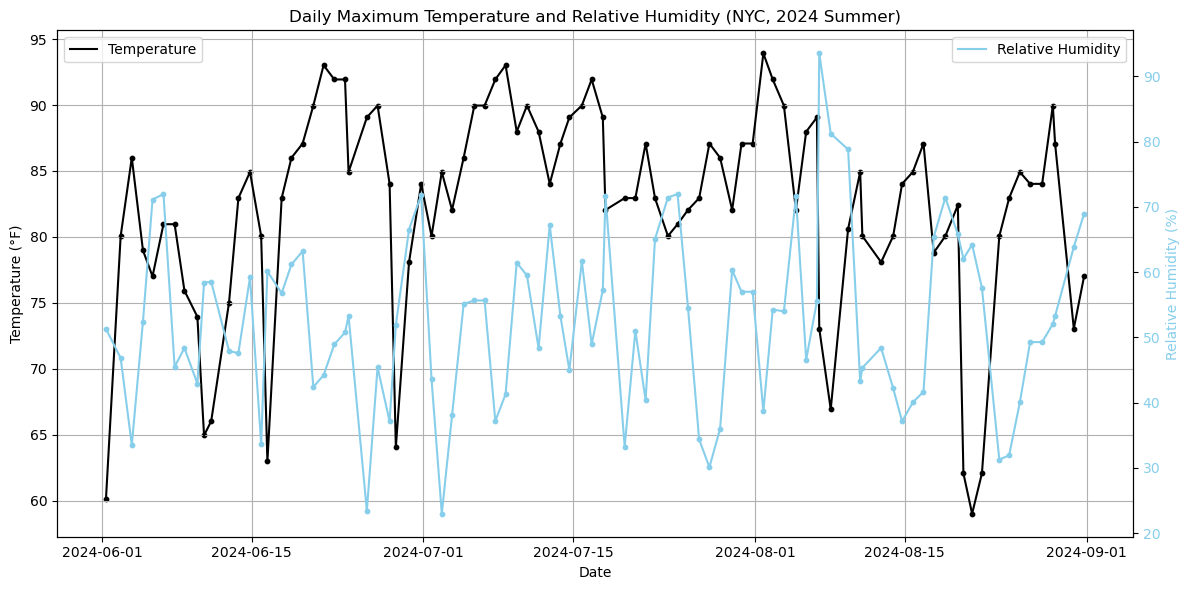

In [8]:
# Daily maximum temperature and relative humidity

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis: Temperature
ax1.plot(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], label='Temperature', color='black')
ax1.scatter(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], color='black', s=10)
#ax1.axhline(90, color='red', linestyle='--', linewidth=1, label='90°F Threshold')
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°F)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title("Daily Maximum Temperature and Relative Humidity (NYC, 2024 Summer)")
ax1.grid(True)
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=0)

# Right Y-axis: Relative Humidity
ax2 = ax1.twinx()
ax2.plot(max_hi_per_day['DATE'], max_hi_per_day['rh'], label='Relative Humidity', color='skyblue')
ax2.scatter(max_hi_per_day['DATE'], max_hi_per_day['rh'], color='skyblue', s=10)
ax2.set_ylabel("Relative Humidity (%)", color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')
ax2.legend(loc='upper right')

# Adjust the layout and save the figure
fig.tight_layout()
plt.savefig("2024_temp_with_rh.png", dpi=300, bbox_inches='tight')
plt.show()

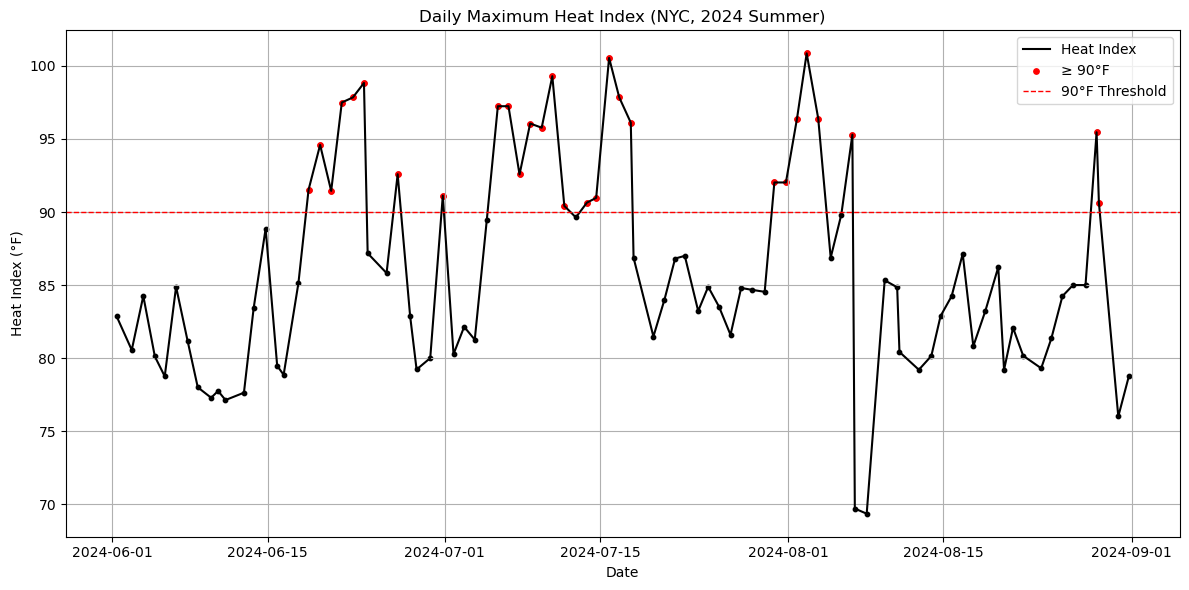

In [9]:
# Daily maximum heat index

# Define red line period
start_red = pd.to_datetime("2024-05-01")
end_red = pd.to_datetime("2024-09-30")

# Create a mask for the red-highlighted period
red_period = (max_hi_per_day['DATE'] >= start_red) & (max_hi_per_day['DATE'] <= end_red)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], label='Heat Index', color='black')

# Point
plt.scatter(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], color='black', s=10)
high_hi = max_hi_per_day[max_hi_per_day['heat_index'] >= 90] # Red point over 90°F
plt.scatter(high_hi['DATE'], high_hi['heat_index'], color='red', s=15, label='≥ 90°F')

# Reference line at 90°F
plt.axhline(90, color='red', linestyle='--', linewidth=1, label='90°F Threshold')

# X axis label
plt.xticks(rotation=0)

# Formatting
plt.title("Daily Maximum Heat Index (NYC, 2024 Summer)")
plt.xlabel("Date")
plt.ylabel("Heat Index (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Save the figure
plt.savefig("2024_heat.png", dpi=300, bbox_inches='tight')

plt.show()

## Heat index over 90°F by hour

In [10]:
# Rows with heat_index higher or same 90
hi_over_90 = weather[weather["is_heat"] == 1]
hi_over_90

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index,is_heat
5519,2024-06-18 16:51:00,"+0300,5","+0217,5",30.0,21.7,86.00,71.06,61.182545,91.527521,1
5520,2024-06-18 17:51:00,"+0294,5","+0217,5",29.4,21.7,84.92,71.06,63.329597,90.171882,1
5544,2024-06-19 16:51:00,"+0300,5","+0222,5",30.0,22.2,86.00,71.96,63.076510,92.238174,1
5545,2024-06-19 17:51:00,"+0306,5","+0228,5",30.6,22.8,87.08,73.04,63.208650,94.592234,1
5546,2024-06-19 18:51:00,"+0294,5","+0217,5",29.4,21.7,84.92,71.06,63.329597,90.171882,1
...,...,...,...,...,...,...,...,...,...,...
7793,2024-08-28 20:51:00,"+0322,5","+0211,5",32.2,21.1,89.96,69.98,52.037773,95.459131,1
7794,2024-08-28 21:51:00,"+0322,5","+0200,5",32.2,20.0,89.96,68.00,48.626518,93.917519,1
7795,2024-08-28 22:51:00,"+0322,5","+0194,5",32.2,19.4,89.96,66.92,46.849570,93.167933,1
7796,2024-08-28 23:51:00,"+0300,5","+0206,5",30.0,20.6,86.00,69.08,57.189798,90.118851,1


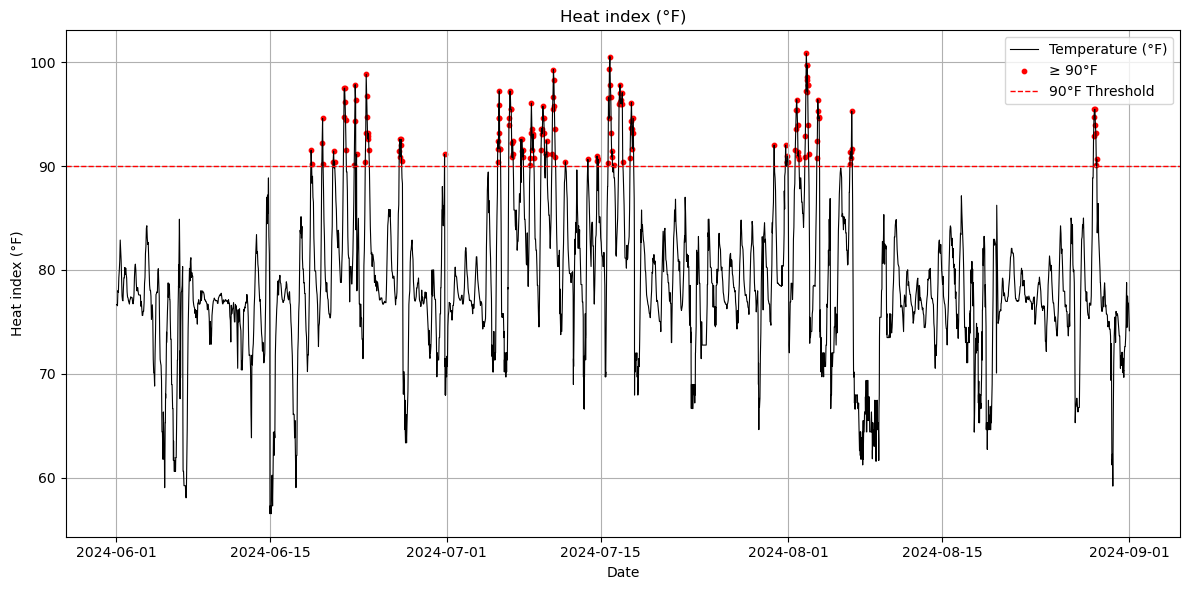

In [11]:
# Heat index graph by hour

plt.figure(figsize=(12, 6))
plt.plot(weather["DATE"], weather["heat_index"], linewidth=0.8, label="Temperature (°F)", color="black")
plt.scatter(hi_over_90['DATE'], hi_over_90['heat_index'], color='red', s=10, label='≥ 90°F')
plt.xlabel("Date")
plt.ylabel("Heat index (°F)")
plt.title("Heat index (°F)")
plt.grid(True)

# Reference line at 90°F
plt.axhline(90, color='red', linestyle='--', linewidth=1, label='90°F Threshold')
plt.legend(loc='upper right')

plt.tight_layout()
plt.xticks(rotation=0)
plt.show()